# 0.0.Entendimento do Problema.

**1.Objetivo do Projeto:** O objetivo do projeto é prever se um cliente vai dar churn ou não, ou seja, no fim projeto eu quero ter alguma forma de identificar os clientes que tem um grande potencial de ser churn.

**2.Para que o projeto vai servir?** Acredito que seja pelo motivo da empresa querer saber previamente qual cliente vai deixa-la, assim podendo fazer campanhas, descontos ou coisas do tipo para que consiga manter aquele cliente e assim não perder dinheiro, pois um cliente churn gera muitos prejuízos para empresa.

**3.Qual a métrica de negócio o projeto vai melhorar?** Esse e um problema que afeta todos os tipos de negócio, por exemplo nesse projeto eu vou ter dados do Telecom que geralmente funcionam como um sistema de assinatura mensal, ou seja, a receita é: Receita = valor assinatura * 12, pensando assim caso o cliente de churn que significa cancelar a assinatura no mês de janeiro o prejuízo para empresa vai ser de: Prejuízo = valor assinatura * 12, pois como e um sistema de assinatura as empresas vão deixar de ganhar 12 vezes o valor da assinatura, por esse motivo que o projeto vai afetar diretamente a renda da empresa pois garantido que tal cliente fique ou já se planejando para o possível cancelamento do cliente a empresa tem menos prejuízo.

**4.Prosposta de Solução:** Para Resolver esse problema eu vou usar dados de cliente que não deram churn e cliente que deram churn, pois com base nesses dados eu posso criar um modelo de ML (Machine Learning) que quando o cliente tiver as mesmas ou semelhante características de um cliente que deu churn no passado, ele já avise a empresa que aquele e um possível churn, e assim fazendo a empresa já preparar alguma campanha de marketing que mantenha o cliente ou se preparar para o potencial prejuízo.

**5.O que vamos querer ter no final do projeto?** Tenho dois objetivos no fim do projeto que são:
- 1.Um modelo que tenha uma acurácia maior de 80%, garantindo assim a boa assertividade das previsões.
- 2.Uma classe que funcione como um API, ou seja, que faça todos os processos de limpeza, Rescaling...etc. nos dados que receber e retorne um arquivo json, para que no futuro o modelo possa ser colocado em produção.

OBS: Eu sei que o problema de churn e um acumulado de perca de dinheiro para empresa, não apenas nos primeiros 12 meses, porém eu quis simplificar o cálculo da receita e prejuízo afins didáticos mesmo.

# 1.0.Impots

In [1]:
##pattern libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
#----------------------------------
#Machine Learning Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing as pp
from keras import models as ml
from keras import layers as l
#----------------------------------
#Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score
from scikitplot import metrics as mt
#----------------------------------

#------------------ProfileReport----------
from pandas_profiling import ProfileReport
#-----------------------------------------

#-------------------
## Statiscts
from scipy import stats
#------------------

#Filter Warnings
import warnings
warnings.filterwarnings("ignore")
#-------------------

#-------------------
## Statiscts
from scipy import stats
#------------------

#Show all columns
pd.set_option('display.max_columns', None)

## 1.1.Load Data

In [2]:
df_raw = pd.read_csv('datasets/Telecom_customer churn.csv')

## 1.2.Help Functions

In [3]:
def cross_validation(model_name,model,num_folds,x_train,y_train,verbose=False):
    
    acurracy_score_list      = []
    Balacend_Acurracy_list   = []
    Kappa_Score_list         = []
    
    #generate k-fold
    Kfold = StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=32)
    i=1
    for train_ix, val_ix in Kfold.split(x_train,y_train):
        if verbose:
            print('Folds: {}/{}'.format(i,num_folds))
            i+=1
        #get folds
        x_train_fold = x_train.iloc[train_ix]
        y_train_fold = y_train.iloc[train_ix]

        x_val_fold = x_train.iloc[val_ix]
        y_val_fold = y_train.iloc[val_ix]
        
        model_trained = model.fit(x_train_fold,y_train_fold)
        
        pred_nn = model_trained.predict(x_val_fold)
        
        acurracy_score = accuracy_score(y_val_fold,pred_nn)
        acurracy_score_list.append(acurracy_score)
        
        Balacend_Acurracy = balanced_accuracy_score(y_val_fold,pred_nn)
        Balacend_Acurracy_list.append(Balacend_Acurracy)
        
        Kappa_Score = cohen_kappa_score(y_val_fold,pred_nn)
        Kappa_Score_list.append(Kappa_Score)
        
    return pd.DataFrame({'Model Name':model_name,
                             'acurracy_score':np.round(np.mean(acurracy_score_list),2).astype(str)+ '+/- '+ np.round(np.std(acurracy_score_list),2).astype(str),
                             'Balacend_Acurracy':np.round(np.mean(Balacend_Acurracy_list),2).astype(str)+ '+/- '+ np.round(np.std(Balacend_Acurracy_list),2).astype(str),
                             'Kappa_Score':np.round(np.mean(Kappa_Score_list),2).astype(str)+ '+/- '+ np.round(np.std(Kappa_Score_list),2).astype(str)},index=[0])   
    
    

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2-(k-1)*(r-1)/(n-1))
    
    kcorr= k - (k-1)**2/(n-1)
    rcorr= r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1,rcorr-1) ))
    
def data_dimensions(data):
    print('Number of rows: {}'.format(data.shape[0]))
    print('Number of columns: {}'.format(data.shape[1]))
    return None

# 2.0.Data Description

In [4]:
df1 = df_raw.copy()
df1.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61,2,1,U,A,N,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,O,15.0,S,S,1.0,M,4.0,3.0,C,A,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,5.666667,0,56,1,1,N,EA,N,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,U,CHICAGO AREA,N,N,NaN,7.0,6.0,WC,1.0,1.0,NaN,1.0,S,S,1.0,M,5.0,1.0,C,A,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,0.0,0.233333,0.0,0.333333,9.000000,6.000000,0.0,0.000000,1,58,1,1,Y,C,N,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,S,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,NaN,0.0,0.0,O,7.0,S,M,2.0,M,5.0,2.0,C,A,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.0,1.333333,0.0,3.666667,0.0,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,0.0,5.450000,0.0,0.000000,3.666667,3.666667,0.0,0.000000,0,60,1,1,Y,B,N,1502,3065.00000,2000.90,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,T,CHICAGO AREA,N,N,29.98999,1.0,1.0,NaN,0.0,0.0,NaN,6.0,M,M,4.0,M,6.0,1.0,C,D,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.0,94.666667,0.0,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.0,0.000000,0,57,1,1,Y,A,N,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,U,NEW ENGLAND AREA,Y,N,149.98999,6.0,4.0,WCMB,0.0,0.0,R,5.0,M,S,1.0,M,6.0,1.0,C,O,0.0,I,U,U,U,U,U,Y,434.0,1000005


## 2.1.Data Dimensions

In [5]:
data_dimensions(df1)

Number of rows: 100000
Number of columns: 100


## 2.2.Data dtypes

In [6]:
np.array(df1.dtypes.values)
pd.DataFrame(np.array(df1.dtypes.values),np.array(df1.dtypes.index)).T

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,object,object,object,int64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,object,object,object,object,float64,float64,float64,object,float64,float64,object,float64,object,object,float64,object,float64,float64,object,object,float64,object,object,object,object,object,object,object,float64,int64


## 2.3.Change dtypes

In [7]:
#None to change

## 2.4.Check NA values

In [8]:
#get only columns with NA valeus
aux = pd.DataFrame(index=df1.isnull().sum().index, data=df1.isnull().sum().values).rename(columns={0:'Values'})
aux1 = aux[aux['Values'] >0].sort_values(by='Values',ascending=False)

#percent of null value
aux1['% null'] = round(100*aux['Values'] / df1.shape[0],2)
aux1[aux1['% null'] < 30]

,Values,% null
income,25436,25.44
adults,23019,23.02
infobase,22079,22.08
hnd_webcap,10189,10.19
prizm_social_one,7388,7.39
avg6mou,2839,2.84
avg6rev,2839,2.84
avg6qty,2839,2.84
kid6_10,1732,1.73
creditcd,1732,1.73


## 2.5.Remove or Fill NA values

**Cretério de Remoção de colunas:**

Colunas com mais de 30% dos valores faltantes eu vou remover.


**Critério de Preenchimento de colunas:**

Vou olhar a distribuição da variável, o valor mais frequente, média, mediana, em busca de achar o melhor valor que condiz com a realidade e não coloca viez nos dados.

**Descrição da análise:**

**Feature Income:** Plotei uma gráfico de histrograma para analisar a distribuição, também analisei a média, median e moda e percebi que estão bem proximas uma das outras, então foi assim que escolhi usar a mediana no preenchimento.

**Feature Adults:** Mesma coisa que fiz na feature de income, e obtive resultados semelhante de proximidade das medidas de pocisão.

**Feature infobase**: Tem um enorme desbalanceamento nos dados, tendo o valor M possuindo 99% dos dados, então ou colocaram N sem querer e foi um erro de sistema ou está variavel está muito desbalancendo, bem mais pra frente vou fazer uma análise por cima de importancia de variável então vou deixar para analisar mais afundo nessa etapa, por enquanto vou substituir os valores faltantes por M mesmo.

**Feature hnd_webcap:** Mesma análise da variavel infobase, tem uma desbalanceamento de dados nas categorias, por enquanto o foco não e selecionar as melhores features então vou deixar como está para tratar mais tarde numa etapa com foco nisso.

Bem essas são as features que eu achei necessario ducocumentar a forma que eu iria prencher os dados, já que ela possuiam mais de 10% dos dados nulos, a partir daqui eu não vou documentar mais pois as variaveis tem menos de 7% de valores nulos então qualquer transformação que eu faça tem poucas chances de causa problemas, embora tratar variaveis categoricas seja complicado pela grande possibilidade de inviezar os dados, mas vou testar substuir pela moda, caso invieze então eu volto aqui e escolho outra abordagem como por exemplo exclui os valores NA

In [9]:
columns_drop = ['numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor'] #cols with more of 30% of valeus NA
df1 = df1.drop(columns_drop,axis=1)

#feature: income
#method: median
df1['income'] = df1['income'].fillna(df1['income'].median())

#feature: adults
#method: median
df1['adults'] = df1['adults'].fillna(df1['adults'].median())

#feature: infobase
#method: mode
df1['infobase'] = df1['infobase'].fillna(df1['infobase'].mode()[0]) 

#feature: hnd_webcap
#method: mode
df1['hnd_webcap'] = df1['hnd_webcap'].fillna(df1['hnd_webcap'].mode()[0])  

#feature: prizm_social_one
#method: mode
df1['prizm_social_one'] = df1['prizm_social_one'].fillna(df1['prizm_social_one'].mode()[0])


#feature: avg6mou
#method: median
df1['avg6mou'] = df1['avg6mou'].fillna(df1['avg6mou'].median()) 

#feature: avg6rev
#method: median
df1['avg6rev'] = df1['avg6rev'].fillna(df1['avg6rev'].mean()) 

#feature: avg6rev
#method: mode
df1['avg6qty'] = df1['avg6qty'].fillna(df1['avg6qty'].mode()[0]) 

#feature: kid6_10
#method: mode
df1['kid6_10'] = df1['kid6_10'].fillna(df1['kid6_10'].mode()[0])

#feature:creditcd
#method: I will consider that null values are customers without credit.
df1['creditcd'] = df1['creditcd'].fillna("N") 

#feature: kid16_17
#method: mode
df1['kid16_17'] = df1['kid16_17'].fillna(df1['kid16_17'].mode()[0])

#feature: kid11_15
#method: mode
df1['kid11_15'] = df1['kid11_15'].fillna(df1['kid11_15'].mode()[0]) 

#feature: rv
#method: mode
df1['rv'] = df1['rv'].fillna(df1['rv'].mode()[0]) 

#feature: truck
#method: mode
df1['truck'] = df1['truck'].fillna(df1['truck'].mode()[0]) 

#feature: kid0_2
#method: mode
df1['kid0_2'] = df1['kid0_2'].fillna(df1['kid0_2'].mode()[0]) 

#feature: kid3_5
#method: mode
df1['kid3_5'] = df1['kid3_5'].fillna(df1['kid3_5'].mode()[0])

#feature: ethnic
#method: mode
df1['ethnic'] = df1['ethnic'].fillna(df1['ethnic'].mode()[0]) 

#feature: forgntvl
#method: mode
df1['forgntvl'] = df1['forgntvl'].fillna(df1['forgntvl'].mode()[0]) 

#feature: marital
#method: mode
df1['marital'] = df1['marital'].fillna(df1['marital'].mode()[0]) 

#feature: change_mou
#method: mode
df1['change_mou'] = df1['change_mou'].fillna(df1['change_mou'].mode()[0]) 

#feature: change_rev
#method: mode
df1['change_rev'] = df1['change_rev'].fillna(df1['change_rev'].mode()[0]) 

#feature: hnd_price
#method: median
df1['hnd_price'] = df1['hnd_price'].fillna(df1['hnd_price'].median()) 

#feature: rev_Mean
#method: mean
df1['rev_Mean'] = df1['rev_Mean'].fillna(df1['rev_Mean'].mean())  
                                                                    
#feature: mou_Mean
#method: mean
df1['mou_Mean'] = df1['mou_Mean'].fillna(df1['mou_Mean'].mean()) 
              
#feature: mou_Mean
#method: mean
df1['ovrmou_Mean'] = df1['ovrmou_Mean'].fillna(df1['ovrmou_Mean'].mean()) 

#feature: roam_Mean
#method: mean
df1['roam_Mean'] = df1['roam_Mean'].fillna(df1['roam_Mean'].mean()) 

#feature: vceovr_Mean
#method: mean
df1['vceovr_Mean'] = df1['vceovr_Mean'].fillna(df1['vceovr_Mean'].mean())

#feature: datovr_Mean
#method: mean
df1['atovr_Mean'] = df1['datovr_Mean'].fillna(df1['datovr_Mean'].mean())                                 
                                                                    
#feature: ovrrev_Mean
#method: mean
df1['ovrrev_Mean'] = df1['ovrrev_Mean'].fillna(df1['ovrrev_Mean'].mean())  

#feature: da_Mean
#method: mean
df1['da_Mean'] = df1['da_Mean'].fillna(df1['da_Mean'].mean())
 
#feature: totmrc_Mean
#method: mean
df1['totmrc_Mean'] = df1['totmrc_Mean'].fillna(df1['totmrc_Mean'].mean())  

#feature: area
#method: mode
df1['area'] = df1['area'].fillna(df1['area'].mode()[0])

#vou excluir o resto dos valores nulos já que são apenas um valor.
df1 = df1.dropna()

## 2.6.Data Description

In [10]:
attributes_num = df1.select_dtypes(include=['int64','float64'])
attributes_cat = df1.select_dtypes(include=['object'])

### 2.6.1.Numerical Data

**Analises das Métricas abaixo:**

Primeira coisa que eu noto e que são tão colunas que não dá nem pra ver a distribuição de todas, por isso eu vou fazer o processo de pegar por index, pegando as primeiras 50 depois as ultimas 50, no caso quando você estiver lendo isso aqui vai estar em default, mas a análise vai ser feita com o parâmetro descartado acima, porém todas passaram por análise, sem exceção.
Outro ponto a se destacar e que eu só vou comentar as features que eu achar que precisem um tratamento como por exemplo, filtrar os dados para que fiquem mais coerentes.

**FEATURES**

**rev_Mean:** Por algum motivo os valores dessa feature então variando de -6 até 3 mil, sendo que mais de 90% dos dados os valores não passam de 400, então com certeza tem algo errado nessa coluna e para resolver isso **Eu vou filtrar os dados dela, para pegar apenas os valores menores que 400**.

**mou_Mean:** Mesmo problema da feature acima, 90% dos dados nessa feature não passam de 3 mil, e estão variando de 0 até mais de 120 mil, por isso **Eu vou fazer o mesmo processo que fiz na feature acima, vou filtrar a coluna para pegar apenas valores abaixo de 3 mil.**

**totmrc_Mean:** Estou começando a crer que todas as features com mean no nome vão ter problemas e tem tantas nos dados 😪, essa também está variando de -26 até 409 sendo que os dados não passam de 200, por isso **Vou filtrar para pegar apenas dados com menos de 200 valores. ** 

**da_Mean:** Mesmo caso das outras por isso **Vou filtrar para pegar apenas os dados com menos de 50 valores. **

**ovrmou_Mean:** **Vou filtrar para pegar dados com menos de 400 valores. **

**ovrrev_Mean: Vou filtrar para pegar apenas valores até 150** 

**vceovr_Mean: Vou filtrar para pegar apenas valores até 150** 

**datovr_Mean: Vou filtrar para pegar apenas valores até 30**

**roam_Mean:   Vou filtrar para pegar apenas valores até 10** 

**change_mou:   Vou filtrar para pegar apenas valores até 1500**

**change_rev: Valores até 300**

**drop_vce_Mean: Valores até 50**

**drop_dat_Mean: Valores até 10**

**blck_vce_Mean: Valores até 100**

**blck_dat_Mean: Até 10**

**unan_vce_Mean: Até 400**

**unan_dat_Mean: Até 10**

**plcd_vce_Mean: Até 1500**

**plcd_dat_Mean: Até 600**

**recv_vce_Mean: Até 600**

**recv_sms_Mean: Até 150**

**comp_vce_Mean: Até 800**

**comp_dat_Mean: Até 150**

**custcare_Mean: Até 100**

**ccrndmou_Mean: Até 300**

**cc_mou_Mean: Até 50**

**inonemin_Mean: Até 300**

**threeway_Mean: Até 20**
 
**mou_cvce_Mean: Até 1500**

**mou_cdat_Mean: Até 100**

**mou_rvce_Mean: Até 100**

**owylis_vce_Mean: Até 200**

**mouowylisv_Mean: até 300**

**iwylis_vce_Mean: Até 100**

**mouiwylisv_Mean: Até 300**

**peak_vce_Mean: Até 600**

**peak_dat_Mean: Até 40**

**mou_peav_Mean: Até 1200**

**mou_pead_Mean: Até 25**

**opk_vce_Mean: Até 600**

**opk_dat_Mean: Até 50**

**mou_opkv_Mean: Até 1500**

**mou_opkd_Mean: Até 50**

**drop_blk_Mean: Até 100**

**attempt_Mean: Até 1000**

**complete_Mean: Até 1000**

**callfwdv_Mean: Até 5**

**callwait_Mean: Até 50**

E assim finalmente acabou as colunas de média, deixei de comentar o motivo da filtragem pelo fato de que todas possuíam o mesmo padrão e para não ser repetitivo decidir apenas documentar o valor até onde a variável vai poder ir, por exemplo a callfwdv_man estava variando de 0 até 200, sendo que apenas 41 valores eram maiores que o valor 5 ou seja, era um desbalanceamento extremo que aconteceu com todas as variáveis, a partir daqui eu vou analisar as outras variáveis, como a coluna de churn pois ai caso tenha um desbalanceamento eu já busco o corrigir nas próximas etapas.


**churn:** Os dados já estamos balanceados, então não será necessário fazer uma etapa de balanceamento.

**uniqsubs:** Os dados estão distribuídos de 1 até 196, sendo que apenas 41 valores são maiores que o valor 8, ou seja, outra coluna com um extremo desbalanceamento, por isso eu vou decidir filtrar também, pois para mim esses valores vão mais prejudicar o modelo do que ajudar. Então vou filtrar para pegar valores abaixo de **8**

**actvsubs** Mesmo problema da variável acima, vou fazer o mesmo processo.

**totcalls:** Somente 256 valores estão acima do valor de 300 mil, sendo que a feature está variando de 0 até 900 mil então eu vou filtrar também.

**totmou:** Apenas 551 valores estão acima do valor de 50 mil, sendo a distribuição está entre 0 e 2 milhões, vou ter que fazer o mesmo processo, limpar isso também, não faz sentido para mim.

**totrev:** Mesma coisa das análises acima, aqui eu vou 634 linhas pois vou filtrar para pegar apenas dados abaixo de 5 mil, pois e onde a grande maioria dos dados está concentrado.

**adjrev:** Mesma coisa da análise acima, até 5 mil também.

**adjmou:** Até 500 mil

**adjqty:** Até 200 mil

**adjmou:** Até 500 mil

**adjqty:** Até 200 mil

**avgrev:** Até 300

**avgmou:** Até 3 mil

**avgqty:** Até 1 mil

**avg3mou:** Até 3 mil

**avg6qty:** Até 1200


In [11]:
#Central tendency mean, median mode
c1 =  pd.DataFrame(attributes_num.apply(np.mean)).T.round(2)
c2 = pd.DataFrame(attributes_num.apply(np.median)).T.round(2)
c3 = pd.DataFrame(attributes_num.apply(lambda x: x.mode()[0])).T.round(2)

#Dispensions - Std-Max-Min-Range
d1 = pd.DataFrame(attributes_num.apply(np.std)).T.round(2)
d2 = pd.DataFrame(attributes_num.apply(min)).T.round(2)
d3 = pd.DataFrame(attributes_num.apply(max)).T.round(2)
d4 = pd.DataFrame(attributes_num.apply(lambda x: x.max() - x.min())).T.round(2)
d5 = pd.DataFrame(attributes_num.apply(lambda x: x.skew())).T.round(2)
d6 = pd.DataFrame(attributes_num.apply(lambda x: x.kurtosis())).T.round(2)

#Concat metrics
metrics = pd.concat([d2,d3,d4,c1,c2,c3,d1,d5,d6]).T.reset_index()
metrics.columns = ['attributes','min','max','range','mean','median','mode','std','skew','kurtosis']
metrics.head()

,attributes,min,max,range,mean,median,mode,std,skew,kurtosis
0,rev_Mean,-6.17,3843.26,3849.43,58.72,48.20,29.99,46.29,9.15,481.31
1,mou_Mean,0.00,12206.75,12206.75,513.57,355.62,0.00,525.17,2.31,10.80
2,totmrc_Mean,-26.92,409.99,436.90,46.18,44.99,44.99,23.62,1.64,9.09
3,da_Mean,0.00,159.39,159.39,0.89,0.25,0.00,2.18,10.81,386.49
4,ovrmou_Mean,0.00,4320.75,4320.75,41.07,2.75,0.00,97.30,7.42,125.77


### 2.6.2.Categorical Data

**ANÁLISE:**

Não há muito o que se fazer na hora de analisar valores categóricos, então abaixo eu vou apenas fazer o describe das variáveis, para verificar a quantidade de valores distintos e se os valores, pois isso vai impactar na hora de encondar os dados.

**FEATURE**

**crclscod:** Essa variável possui 54 valores distintos e importante saber isso pois na hora de encondar os dados e caso essa feature sobreviva as próximas fases de análises, eu vou ter que ter outra estratégia de enconder.

In [12]:
attributes_cat.describe()

,new_cell,crclscod,asl_flag,prizm_social_one,area,dualband,refurb_new,hnd_webcap,marital,infobase,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd
count,99642,99642,99642,99642,99642,99642,99642,99642,99642,99642,99642,99642,99642,99642,99642,99642,99642
unique,3,54,2,5,19,4,2,3,5,2,17,2,2,2,2,2,2
top,U,AA,N,S,NEW YORK CITY AREA,Y,N,WCMB,U,M,N,U,U,U,U,U,Y
freq,66633,36494,85760,39345,11121,72083,85295,85680,38903,99418,35028,95644,94961,91596,90856,89703,67015


In [13]:
data_dimensions(df1)

Number of rows: 99642
Number of columns: 95


# 3.0.Feature Engienner

In [14]:
df2 = df1.copy()
df2.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,marital,adults,infobase,income,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID,atovr_Mean
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61,2,1,U,A,N,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,S,1.0,M,4.0,0.0,N,U,U,U,U,U,Y,361.0,1000001,0.0
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,5.666667,0,56,1,1,N,EA,N,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,U,CHICAGO AREA,N,N,99.98999,7.0,6.0,WC,1.0,1.0,S,1.0,M,5.0,0.0,Z,U,U,U,U,U,Y,240.0,1000002,0.0
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,0.0,0.233333,0.0,0.333333,9.000000,6.000000,0.0,0.000000,1,58,1,1,Y,C,N,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,S,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,WCMB,0.0,0.0,M,2.0,M,5.0,0.0,N,U,Y,U,U,U,Y,1504.0,1000003,0.0
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.0,1.333333,0.0,3.666667,0.0,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,0.0,5.450000,0.0,0.000000,3.666667,3.666667,0.0,0.000000,0,60,1,1,Y,B,N,1502,3065.00000,2000.90,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,T,CHICAGO AREA,N,N,29.98999,1.0,1.0,WCMB,0.0,0.0,M,4.0,M,6.0,0.0,U,Y,U,U,U,U,Y,1812.0,1000004,0.0
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.0,94.666667,0.0,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.0,0.000000,0,57,1,1,Y,A,N,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,U,NEW ENGLAND AREA,Y,N,149.98999,6.0,4.0,WCMB,0.0,0.0,S,1.0,M,6.0,0.0,I,U,U,U,U,U,Y,434.0,1000005,0.0


In [15]:
df2.columns

Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou',
       'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean',
       'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean',
       'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean',
       'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean',
       'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean',
       'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean',
       'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean',
       'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean',
       'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean',
       'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'churn', 'months',
       'uniqsubs', 'actvsubs', 'new_cell', 'crclscod', 'asl_flag', 'totcalls',
       'totmou', 'totrev', 'adjrev'

## 3.1.New_Columns

**Criação de Features:**

Não vejo nenhuma feature que possa ser modificada ou que possa ter algum valor extraido, o que temos e muitas features que precisam ser removidas, então eu não vou criar nenhuam feature pois não me parece necessario, esses dados são meio estranhos cheio de médias e coisas que não fazem sentido para mim aind, porém vou continuar o projeto, até achar que não vale mais a pena.

# 4.0.Data Filtering

In [16]:
df2 = df1.copy()
df2.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,marital,adults,infobase,income,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID,atovr_Mean
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61,2,1,U,A,N,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,S,1.0,M,4.0,0.0,N,U,U,U,U,U,Y,361.0,1000001,0.0
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,5.666667,0,56,1,1,N,EA,N,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,U,CHICAGO AREA,N,N,99.98999,7.0,6.0,WC,1.0,1.0,S,1.0,M,5.0,0.0,Z,U,U,U,U,U,Y,240.0,1000002,0.0
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,0.0,0.233333,0.0,0.333333,9.000000,6.000000,0.0,0.000000,1,58,1,1,Y,C,N,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,S,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,WCMB,0.0,0.0,M,2.0,M,5.0,0.0,N,U,Y,U,U,U,Y,1504.0,1000003,0.0
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.0,1.333333,0.0,3.666667,0.0,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,0.0,5.450000,0.0,0.000000,3.666667,3.666667,0.0,0.000000,0,60,1,1,Y,B,N,1502,3065.00000,2000.90,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,T,CHICAGO AREA,N,N,29.98999,1.0,1.0,WCMB,0.0,0.0,M,4.0,M,6.0,0.0,U,Y,U,U,U,U,Y,1812.0,1000004,0.0
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.0,94.666667,0.0,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.0,0.000000,0,57,1,1,Y,A,N,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,U,NEW ENGLAND AREA,Y,N,149.98999,6.0,4.0,WCMB,0.0,0.0,S,1.0,M,6.0,0.0,I,U,U,U,U,U,Y,434.0,1000005,0.0


## 4.1.Filter Columns

In [17]:
cols = ['datovr_Mean','drop_dat_Mean','forgntvl','blck_dat_Mean','unan_dat_Mean','plcd_dat_Mean','recv_sms_Mean','comp_dat_Mean','mou_cdat_Mean',
'peak_dat_Mean','mou_pead_Mean','opk_dat_Mean','mou_opkd_Mean','callfwdv_Mean','infobase','kid0_2','kid3_5',
'kid6_10','kid11_15','kid16_17','atovr_Mean'] #columns with large numbers of values 0 or repetitions
df2 = df2.drop(cols,axis=1)

## 4.2.Filter Rows

In [18]:
df2 = df2[df2['rev_Mean'] < 400]
df2 = df2[df2['mou_Mean'] < 3000]
df2 = df2[df2['totmrc_Mean'] < 200]
df2 = df2[df2['da_Mean'] < 50] 
df2 = df2[df2['ovrmou_Mean'] < 400]
df2 = df2[df2['ovrrev_Mean'] < 150]
df2 = df2[df2['ovrrev_Mean'] < 150]
df2 = df2[df2['vceovr_Mean'] < 150]
df2 = df2[df2['roam_Mean'] < 10]
df2 = df2[df2['change_mou'] < 1500]
df2 = df2[df2['change_mou'] < 1500]
df2 = df2[df2['change_rev'] < 300]
df2 = df2[df2['drop_vce_Mean'] < 50]
df2 = df2[df2['blck_vce_Mean'] < 100]
df2 = df2[df2['unan_vce_Mean'] < 400]
df2 = df2[df2['plcd_vce_Mean'] < 1500]
df2 = df2[df2['recv_vce_Mean'] < 600]
df2 = df2[df2['comp_vce_Mean'] < 800]
df2 = df2[df2['custcare_Mean'] < 100]
df2 = df2[df2['ccrndmou_Mean'] < 300]
df2 = df2[df2['cc_mou_Mean'] < 50]
df2 = df2[df2['inonemin_Mean'] < 300]
df2 = df2[df2['threeway_Mean'] < 20]
df2 = df2[df2['mou_cvce_Mean'] < 1500]
df2 = df2[df2['mou_rvce_Mean'] < 1000]
df2 = df2[df2['owylis_vce_Mean'] < 200]
df2 = df2[df2['mouowylisv_Mean'] < 300]
df2 = df2[df2['iwylis_vce_Mean'] < 100]
df2 = df2[df2['mouiwylisv_Mean'] < 300]
df2 = df2[df2['peak_vce_Mean'] < 600]
df2 = df2[df2['mou_peav_Mean'] < 1200]
df2 = df2[df2['opk_vce_Mean'] < 600]
df2 = df2[df2['mou_opkv_Mean'] < 1500]
df2 = df2[df2['drop_blk_Mean'] < 100]
df2 = df2[df2['attempt_Mean'] < 1000]
df2 = df2[df2['complete_Mean'] < 1000]
df2 = df2[df2['callwait_Mean'] < 50]
df2 = df2[df2['uniqsubs'] < 8]
df2 = df2[df2['actvsubs'] < 8]
df2 = df2[df2['totcalls'] < 30000]
df2 = df2[df2['totmou'] < 50000]
df2 = df2[df2['totrev'] < 5000]
df2 = df2[df2['adjrev'] < 5000]
df2 = df2[df2['adjmou'] < 50000] 
df2 = df2[df2['adjqty'] < 50000] 
df2 = df2[df2['avgrev'] < 300] 
df2 = df2[df2['avgmou'] < 3000] 
df2 = df2[df2['avgqty'] < 3000] 
df2 = df2[df2['avg3mou'] < 3000] 
df2 = df2[df2['avg6rev'] < 300]

In [19]:
data_dimensions(df2)

Number of rows: 92458
Number of columns: 74


# 5.Exploratory Data Analysis

In [20]:
df3 = df2.copy()
df3.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,blck_vce_Mean,unan_vce_Mean,plcd_vce_Mean,recv_vce_Mean,comp_vce_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,mou_peav_Mean,opk_vce_Mean,mou_opkv_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,marital,adults,income,ethnic,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.666667,6.333333,52.333333,42.333333,45.000000,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,132.600000,24.000000,55.220000,1.333333,52.333333,45.000000,0.333333,1,61,2,1,U,A,N,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,S,1.0,4.0,N,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,532.25,50.9875,8.333333,1.000000,61.333333,263.333333,69.000000,193.333333,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,75.333333,157.000000,169.343333,9.333333,263.333333,193.333333,5.666667,0,56,1,1,N,EA,N,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,U,CHICAGO AREA,N,N,99.98999,7.0,6.0,WC,1.0,1.0,S,1.0,5.0,Z,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.000000,2.666667,9.000000,0.333333,6.000000,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.193333,1.000000,0.233333,0.333333,9.000000,6.000000,0.000000,1,58,1,1,Y,C,N,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,S,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,WCMB,0.0,0.0,M,2.0,5.0,N,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,-1.50,0.0000,0.000000,0.000000,0.000000,3.666667,1.333333,3.666667,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,3.380000,3.666667,5.450000,0.000000,3.666667,3.666667,0.000000,0,60,1,1,Y,B,N,1502,3065.00000,2000.90,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,T,CHICAGO AREA,N,N,29.98999,1.0,1.0,WCMB,0.0,0.0,M,4.0,6.0,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,38.50,0.0000,9.666667,0.666667,77.000000,222.333333,94.666667,137.000000,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,173.476667,90.333333,218.086667,10.333333,222.333333,137.000000,0.000000,0,57,1,1,Y,A,N,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,U,NEW ENGLAND AREA,Y,N,149.98999,6.0,4.0,WCMB,0.0,0.0,S,1.0,6.0,I,Y,434.0,1000005


## 5.1.Univariate Analysis

**Analise Da Distribuição:** Analisando o gráfico abaixo, podemos ver que não temos dados desbalanceados, ou seja, temos uma quantidade de valor churn e não churn equivalente, isso e essencial para que os modelos de ML consigam identificar se o cliente vai ser churn ou não.

0 = Cliente não churn e 1= Cliente churn

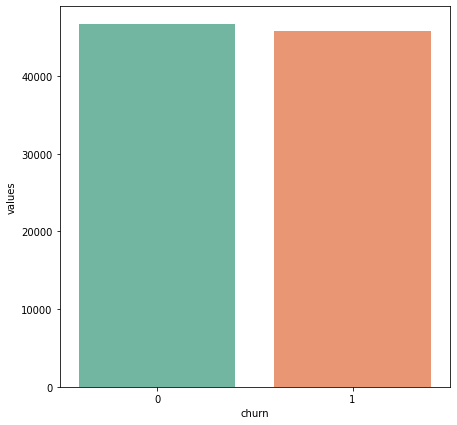

In [21]:
plt.figure(figsize=(7,7))
sns.barplot(x=df3['churn'].value_counts().index,y=df3['churn'].value_counts(),palette='Set2')
plt.xlabel('churn')
plt.ylabel('values');

## 5.2.Numerical Variables and Categorical Variables

**Pandas Profiling:** Vou usar o relatório do pandas para identificar se existem muitos valores distintos nos dados, ou seja, que realmente possuem algum valor, caso não eu vou detalhar abaixo o porquê da exclusão da coluna.

**Critério de remoção de colunas: Todas as colunas com mais de 85% dos valores repetidos serão excluídas.**

Colunas que serão/foram removidas(análise feita no pandas profiling):
- datovr_Mean
- drop_dat_Mean
- blck_dat_Mean
- unan_dat_Mean
- plcd_dat_Mean
- recv_sms_Mean
- comp_dat_Mean
- mou_cdat_Mean
- peak_dat_Mean
- mou_pead_Mean
- opk_dat_Mean
- mou_opkd_Mean
- callfwdv_Mean
- infobase
- kid0_2
- kid3_5
- kid6_10
- kid11_15
- kid11_17
- atovr_Mean

O código abaixo está comentado, pois para executar o relatório leva um tempinho e ele fica grande de mais, por isso não vou deixa aberto e nem vou disponibilizar o relatório pois ele trava na hora de abrir no navegador, me permitindo ver apenas a quantidade de valores únicos em cada coluna.

In [22]:
#pandas profiling
#profile = ProfileReport(df3)

#Save in html
#profile.to_file(f'profiles/Univariate_analysis_clean.html')

## 5.3.Bivariate Analysis

### H1: Clientes com mais de 30 meses na base são 30% dos meus clientes churn.
**FALSA:** Clientes com mais de 30 meses SÃO **85%** DOS MEUS CLIENTES CHURN.

In [23]:
aux_churn_after_30_months = df3[(df3['months'] > 30) & (df3['churn'] == 1)].shape[0]
aux_churn_before_30_months = df3[(df3['months'] < 30) & (df3['churn'] == 1)].shape[0]

aux = pd.DataFrame({'Clientes churn com mais de 30 meses':aux_churn_before_30_months,
                    'Clientes churn com menos de 30 meses':aux_churn_after_30_months},index=[0]).T
aux.columns = ['Values']
aux['% Difference'] = round(100*aux['Values'].pct_change(),2).fillna(0)
aux

,Values,% Difference
Clientes churn com mais de 30 meses,39360,0.00
Clientes churn com menos de 30 meses,5797,-85.27


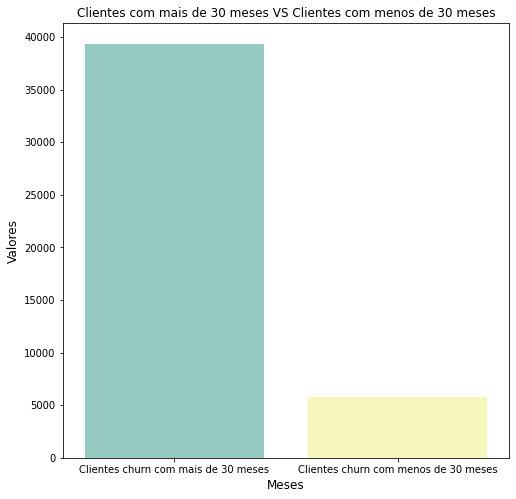

In [24]:
plt.figure(figsize=(8,8))
sns.barplot(x=aux.index, y=aux['Values'], palette='Set3')
plt.xlabel('Meses',fontsize=12)
plt.ylabel('Valores',fontsize=12)
plt.title('Clientes com mais de 30 meses VS Clientes com menos de 30 meses',fontsize=12);

### H2: Clientes com income maior ou igual a 4 são 30% mais churn do que os outros clientes.
**VARDADEIRA:** Clientes com income maior ou igual a 4 são 87% MAIS CHURN DO QUE OS OUTROS CLIENTES.

In [25]:
aux_churn_income_after_4 = df3[(df3['income'] >= 4) & (df3['churn']==1)].shape[0]
aux_churn_income_before_4 = df3[(df3['income'] <= 3) & (df3['churn']==1)].shape[0]

aux = pd.DataFrame({'Clientes_Churn_com_Salarios_altos':aux_churn_income_after_4,
                    'Clientes_Churn_com_Salarios_Baixos':aux_churn_income_before_4},index=[0]).T
aux.columns = ['Values']

aux['Difference %'] = round(100*aux['Values'].pct_change(),2).fillna(0)
aux

,Values,Difference %
Clientes_Churn_com_Salarios_altos,40462,0.00
Clientes_Churn_com_Salarios_Baixos,5368,-86.73


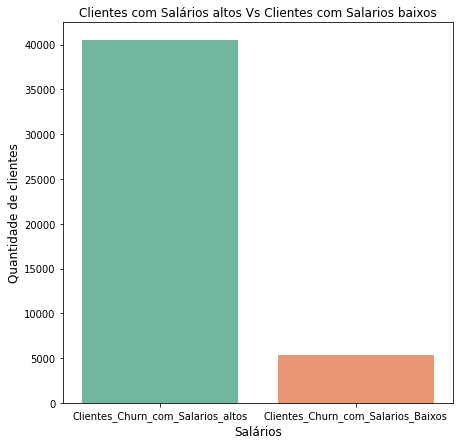

In [26]:
plt.figure(figsize=(7,7))
sns.barplot(x=aux.index, y=aux['Values'], palette='Set2')
plt.xlabel('Salários',fontsize=12)
plt.ylabel('Quantidade de clientes',fontsize=12)
plt.title('Clientes com Salários altos Vs Clientes com Salarios baixos',fontsize=12);

### H3: Cliente com dias de eqpdays maior ou igual a 1000 são 40% churn que os outros.
**FALSA:** Clientes com eqpdays maior de 1000 REPRESENTAM MENOS DE 4% DOS MEUS CLIENTES CHURN.

In [27]:
aux_eqpdays_after_1000 = df3[ (df3['eqpdays'] >= 1000) & (df3['churn']==1)].shape[0]
aux_eqpdays_before_1000 = df3[ (df3['eqpdays'] < 1000) & (df3['churn']==1)].shape[0]
aux = pd.DataFrame({'Churn_epqdays_before_1000':aux_eqpdays_before_1000,
                   'Churn_eqpdays_after_1000':aux_eqpdays_after_1000},index=[0]).T
aux.columns = ['Values']
aux['Difference %'] = round(100*aux['Values'].pct_change(),2).fillna(0)
aux

,Values,Difference %
Churn_epqdays_before_1000,44260,0.00
Churn_eqpdays_after_1000,1570,-96.45


### H4: Clientes com credito aprovado são 30% ou mais churn que os outros clientes.
**VERDADEIRA:** Clientes com credito aprovado são **104%** MAIS CHURN DOS QUE OS CLIENTES SEM CRÉDITO APROVADO.

In [28]:
aux = df3[(df3['creditcd'] == 'Y') & (df3['churn']==1)].shape[0]
aux1 = df3[(df3['creditcd'] == 'N') & (df3['churn']==1)].shape[0]

aux2 = pd.DataFrame({'Credit_not_approved':aux1,
                     'Credit_approved':aux},index=[0]).T

aux2.columns = ['Values']
aux2['Difference %'] = round(aux2['Values'].pct_change(),2).fillna(0)
aux2

,Values,Difference %
Credit_not_approved,15035,0.00
Credit_approved,30795,1.05


### H5: Clientes com mais de 4 pessoas adultas na familia são 30% mais churn do que os outros.
**FALSA:** Clientes com mais de 4 pessoas na fámilia são 79% MENOS CHURN do que os outros clientes

In [29]:
aux  = df3[ (df3['adults'] >= 4)   &  (df3['churn'] == 1)].shape[0]
aux1 = df3[ (df3['adults'] <= 3) &  (df3['churn'] == 1)].shape[0]

aux2 = pd.DataFrame({'Menos_de_4_adultos':aux1,
                     'Mais_de_4_adultos':aux},index=[0]).T 
aux2.columns = ['Values']

aux2['Difference %'] = round(aux2['Values'].pct_change(),2).fillna(0)
aux2

,Values,Difference %
Menos_de_4_adultos,37746,0.00
Mais_de_4_adultos,8084,-0.79


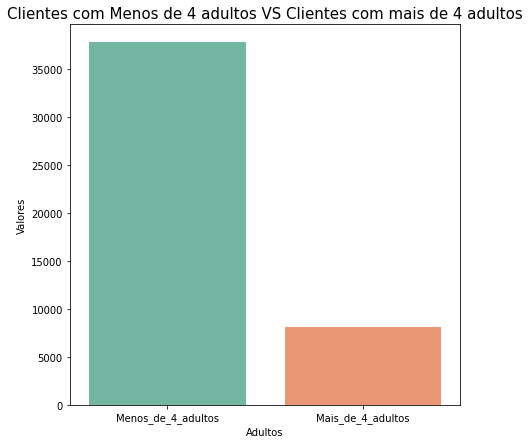

In [30]:
plt.figure(figsize=(7,7))
sns.barplot(x=aux2['Values'].index,y=aux2['Values'].values, palette='Set2')
plt.xlabel('Adultos')
plt.ylabel('Valores')
plt.title('Clientes com Menos de 4 adultos VS Clientes com mais de 4 adultos',fontsize=15);

## 5.4.Multvariate Analysis

### 5.4.1.Numerical Data

**Critério de Remoção de Colunas:**
Colunas com uma correlação mais alta do que 85% serão removidas/foram.

**Como será/foi feita a análise?**
Como a base tinha muitas colunas, ficou inviável que eu avaliasse as correlações de todas as colunas juntas, pois não dava para enxergar, para resolver isso eu salvei o gráfico em png, abri no navegador, usei uma ferramenta de corte do Windows e
com ela eu cortei um pedaço da parte inferior do gráfico e analisei fazendo riscos, assim visualizando as correlações mais fortes, removi e por fim recriando o gráfico sem elas, esse processo pode ser visto na pasta de 'Images', foi uma forma que achei adequada para resolver o problema.

- Colunas removidas: Abaixo

In [31]:
cols_remv = ['peak_vce_Mean','opk_vce_Mean','attempt_Mean','totmou','adjmou','avgmou','avg3rev','avg6mou','avg6rev',
             'mou_opkv_Mean','plcd_vce_Mean','totmou','avgmou','avgqty','ccrndmou_Mean','mou_cvce_Mean','owylis_vce_Mean',
             'avg3mou','avg3qty','recv_vce_Mean','phones','vceovr_Mean','ovrrev_Mean'
            ]
print('Number of Columns to remove: {}'.format(len(cols_remv)))

Number of Columns to remove: 23


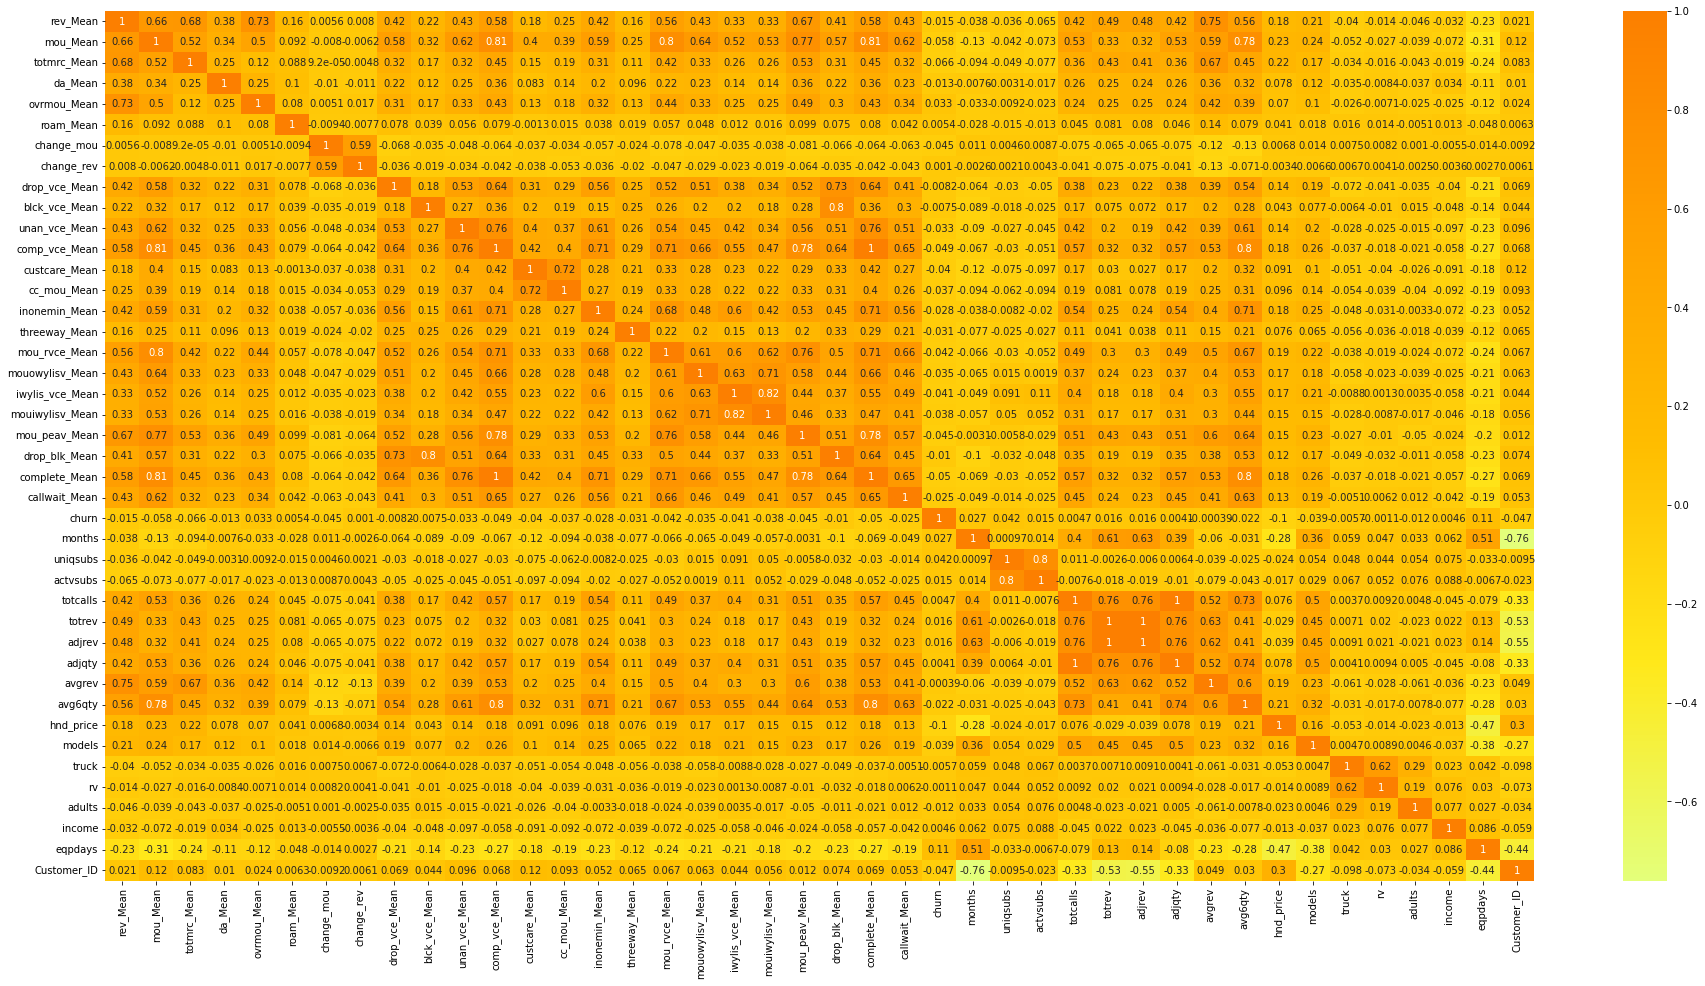

In [32]:
plt.figure(figsize=(32,16))
sns.heatmap(df3.drop(cols_remv,axis=1).corr(),annot=True,cmap='Wistia');

### 5.4.2.Categorical Data 
**Análise:**
Nenhuma coluna cumpre o requisito de 85% de correlação para ser excluida, por isso não vou excluir nenhuma.

In [33]:
cat_attributes = df3.select_dtypes(include=['object'])

In [34]:
cat_attributes_list = cat_attributes.columns.tolist()
corr_dict = {}

for i in range(len(cat_attributes_list)):
    corr_ls = []
    for j in range(len(cat_attributes_list)):
        ref  = cat_attributes_list[i]
        feat = cat_attributes_list[j]   
        
        #correlations
        corr = cramer_v(cat_attributes[ref],cat_attributes[feat])
        
        #append list
        corr_ls.append(corr)
    #append a correlation list for each ref attributes
    corr_dict[ref] = corr_ls

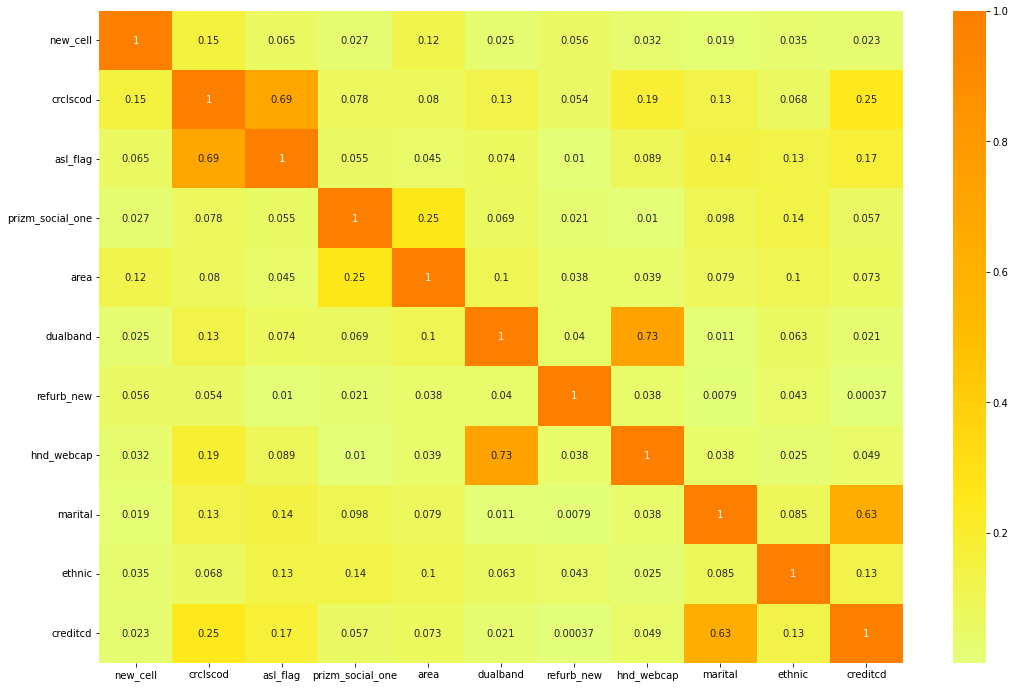

In [35]:
#Correlations to dataframe
categorical_corr = pd.DataFrame(corr_dict)
categorical_corr = categorical_corr.set_index(categorical_corr.columns)

#Show correlations
plt.figure(figsize=(18,12))
sns.heatmap(categorical_corr,cmap='Wistia',annot=True);

In [36]:
#Removed columns
df3 = df3.drop(cols_remv,axis=1)

#dimensions
data_dimensions(df3)

Number of rows: 92458
Number of columns: 53


# 6.Data Preparation

In [37]:
df4 = df3.copy()

In [38]:
#one hot enconder in categorical data
df4 = pd.get_dummies(df4)

In [39]:
data_dimensions(df4)

Number of rows: 92458
Number of columns: 157


# 7.Feature Selection

In [40]:
df5 = df4.copy()
df5.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,blck_vce_Mean,unan_vce_Mean,comp_vce_Mean,custcare_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_rvce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,mou_peav_Mean,drop_blk_Mean,complete_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,totcalls,totrev,adjrev,adjqty,avgrev,avg6qty,hnd_price,models,truck,rv,adults,income,eqpdays,Customer_ID,new_cell_N,new_cell_U,new_cell_Y,crclscod_A,crclscod_A2,crclscod_A3,crclscod_AA,crclscod_B,crclscod_B2,crclscod_BA,crclscod_C,crclscod_C2,crclscod_C5,crclscod_CA,crclscod_CC,crclscod_CY,crclscod_D,crclscod_D2,crclscod_D4,crclscod_D5,crclscod_DA,crclscod_E,crclscod_E2,crclscod_E4,crclscod_EA,crclscod_EC,crclscod_EF,crclscod_EM,crclscod_G,crclscod_GA,crclscod_GY,crclscod_H,crclscod_I,crclscod_IF,crclscod_J,crclscod_JF,crclscod_K,crclscod_L,crclscod_M,crclscod_O,crclscod_P1,crclscod_S,crclscod_TP,crclscod_U,crclscod_U1,crclscod_V,crclscod_V1,crclscod_W,crclscod_Y,crclscod_Z,crclscod_Z1,crclscod_Z2,crclscod_Z4,crclscod_Z5,crclscod_ZA,crclscod_ZY,asl_flag_N,asl_flag_Y,prizm_social_one_C,prizm_social_one_R,prizm_social_one_S,prizm_social_one_T,prizm_social_one_U,area_ATLANTIC SOUTH AREA,area_CALIFORNIA NORTH AREA,area_CENTRAL/SOUTH TEXAS AREA,area_CHICAGO AREA,area_DALLAS AREA,area_DC/MARYLAND/VIRGINIA AREA,area_GREAT LAKES AREA,area_HOUSTON AREA,area_LOS ANGELES AREA,area_MIDWEST AREA,area_NEW ENGLAND AREA,area_NEW YORK CITY AREA,area_NORTH FLORIDA AREA,area_NORTHWEST/ROCKY MOUNTAIN AREA,area_OHIO AREA,area_PHILADELPHIA AREA,area_SOUTH FLORIDA AREA,area_SOUTHWEST AREA,area_TENNESSEE AREA,dualband_N,dualband_T,dualband_U,dualband_Y,refurb_new_N,refurb_new_R,hnd_webcap_UNKW,hnd_webcap_WC,hnd_webcap_WCMB,marital_A,marital_B,marital_M,marital_S,marital_U,ethnic_B,ethnic_C,ethnic_D,ethnic_F,ethnic_G,ethnic_H,ethnic_I,ethnic_J,ethnic_M,ethnic_N,ethnic_O,ethnic_P,ethnic_R,ethnic_S,ethnic_U,ethnic_X,ethnic_Z,creditcd_N,creditcd_Y
0,23.9975,219.25,22.500,0.2475,0.00,0.0,-157.25,-18.9975,0.666667,0.666667,6.333333,45.000000,0.000000,0.000000,18.000000,0.000000,97.176667,0.000000,0.000000,0.000000,132.600000,1.333333,45.000000,0.333333,1,61,2,1,1652,1504.62,1453.44,1602,29.66,136.0,149.98999,2.0,0.0,0.0,1.0,4.0,361.0,1000001,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,57.4925,482.75,37.425,0.2475,22.75,0.0,532.25,50.9875,8.333333,1.000000,61.333333,193.333333,1.666667,5.463333,53.000000,0.333333,55.280000,24.216667,6.333333,3.696667,75.333333,9.333333,193.333333,5.666667,0,56,1,1,14654,2851.68,2833.88,14624,51.53,275.0,99.98999,6.0,1.0,1.0,1.0,5.0,240.0,1000002,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,16.9900,10.25,16.990,0.0000,0.00,0.0,-4.25,0.0000,0.333333,0.000000,2.666667,6.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,5.193333,0.333333,6.000000,0.000000,1,58,1,1,7903,2155.91,1934.47,7888,34.54,6.0,29.98999,1.0,0.0,0.0,2.0,5.0,1504.0,1000003,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,38.0000,7.50,38.000,0.0000,0.00,0.0,-1.50,0.0000,0.000000,0.000000,0.000000,3.666667,0.000000,0.000000,1.333333,0.000000,0.413333,0.256667,0.000000,0.000000,3.380000,0.000000,3.666667,0.000000,0,60,1,1,1502,2000.90,1941.81,1479,40.45,25.0,29.98999,1.0,0.0,0.0,4.0,6.0,1812.0,1000004,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0

In [41]:
X = df5.drop('churn',axis=1)
y = df5['churn']

# 8.Machine Learning

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=32)

In [43]:
#drop customer id
x_train = X_train.drop('Customer_ID',axis=1)
x_test = X_test.drop('Customer_ID',axis=1)

## 8.1Gaussian NB

In [44]:
model_gaussian = GaussianNB()

#train model
model_gaussian.fit(x_train,y_train)

#predict
result_gausian = model_gaussian.predict(x_test)

## 8.2.LogisticRegression

In [45]:
model_logic = LogisticRegression()

#train data
model_logic.fit(x_train,y_train)

#predict
result_logic = model_logic.predict(x_test)

# 9.0.Perfomance

## Simple Perfomance

### 9.1.Gausian nb Model

Accuracy Score Gausian: 54.79%
              precision    recall  f1-score   support

           0       0.59      0.36      0.44     14006
           1       0.53      0.74      0.62     13732

    accuracy                           0.55     27738
   macro avg       0.56      0.55      0.53     27738
weighted avg       0.56      0.55      0.53     27738



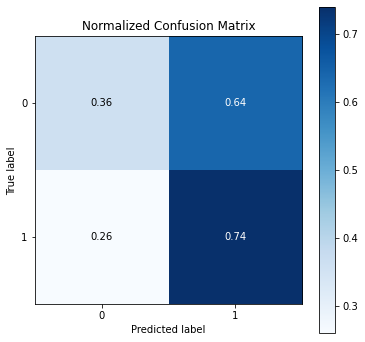

In [46]:
#accuracy
print('Accuracy Score Gausian: {:.2%}'.format(accuracy_score(y_test,result_gausian)))
#Model Gausian
print(classification_report(y_test,result_gausian))

#Model Gausian
mt.plot_confusion_matrix(y_test, result_gausian, normalize=True, figsize=(6,6));

### 9.2.Logistic Regression

Accuracy Score Logistic Regression: 57.74%
              precision    recall  f1-score   support

           0       0.58      0.60      0.59     14006
           1       0.58      0.55      0.56     13732

    accuracy                           0.58     27738
   macro avg       0.58      0.58      0.58     27738
weighted avg       0.58      0.58      0.58     27738



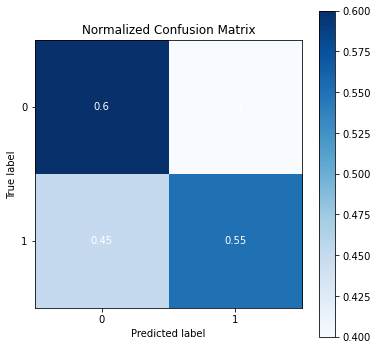

In [47]:
#accuracy
print('Accuracy Score Logistic Regression: {:.2%}'.format(accuracy_score(y_test,result_logic)))
#Model Gausian
print(classification_report(y_test,result_logic))

#Model Gausian
mt.plot_confusion_matrix(y_test, result_logic, normalize=True, figsize=(6,6));

## 9.3.Cross Validation Perfomance

### 9.3.1.Gausian Nb Cross Val

In [48]:
model_gausian_cross = GaussianNB()
cross_validation("Gausian NB",model_gausian_cross,5,x_train,y_train,verbose=True)

Folds: 1/5
Folds: 2/5
Folds: 3/5
Folds: 4/5
Folds: 5/5


,Model Name,acurracy_score,Balacend_Acurracy,Kappa_Score
0,Gausian NB,0.55+/- 0.0,0.55+/- 0.0,0.1+/- 0.01


### 9.3.2.Logistic Regression Cross Val

In [49]:
mode_logistic_cross = LogisticRegression()
cross_validation("Logistic Regression",mode_logistic_cross,5,x_train,y_train,verbose=True)

Folds: 1/5
Folds: 2/5
Folds: 3/5
Folds: 4/5
Folds: 5/5


,Model Name,acurracy_score,Balacend_Acurracy,Kappa_Score
0,Logistic Regression,0.57+/- 0.0,0.57+/- 0.0,0.15+/- 0.01


# Conclusão

**O que foi feito nessa etapa?**
- Exploratoty_Data_Analysis:
    - Essa e uma das etapas mais longas do projeto, pois requer uma análise de coluna por coluna, verificando a correlação, distribuição, entre outras metricas, graças a isso eu agora estou levando bem menos colunas para as outras etapas e essas colunas são realmente relevantes para o projeto, agora a etapa de enconder vai ser mais tranquila pois vai ter menos colunas para encondar. 

**O que será feito na próxima etapa?**
- Data Preparation:
    - Nessa etapa eu vou encondar e fazer os rescaling de dados, isso vai aumentar a perfomance do modelo e colocar as distribuições mais perto de uma normal, fazendo assim que os calculos que o modelo de ML Vai fazer sejam mais simples e precisos.
    
    
**Próxima Etapa:**
Data Preparation